=== 원본 데이터 성능 ===
Mean Squared Error: 2.6148
R2 Score: 0.9546

=== 증강 데이터 성능 ===
Mean Squared Error: 1.9914
R2 Score: 0.9630


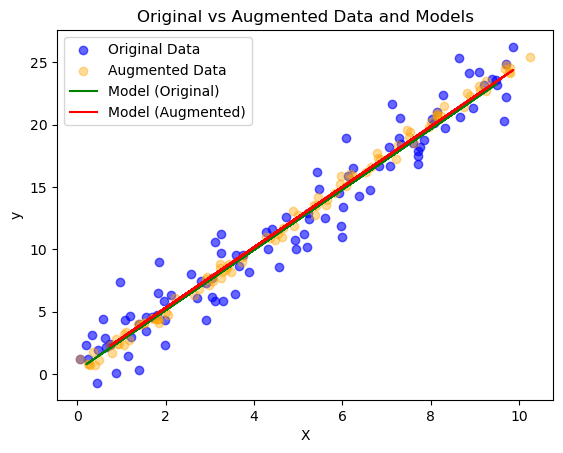

In [13]:
#############################################################
# [1] 데이터 처리 및 변환
# [1-1] 데이터 증강 (Data Augmentation)
# 숫자 데이터 : 노이즈와 비선형성 추가
#############################################################
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# 원본 데이터 생성
np.random.seed(42)
X = np.random.rand(100, 1) * 10  # Feature
y = 2.5 * X.flatten() + np.random.randn(100) * 2  # Target with noise

# 원본 데이터프레임
original_data = pd.DataFrame({"X": X.flatten(), "y": y})

# 데이터 증강: 노이즈와 비선형성 추가
augmented_X = X + np.random.randn(100, 1) * 0.2  # 작은 노이즈 추가
augmented_y = 2.5 * augmented_X.flatten() + np.random.randn(100) * 0.5 + 0.2 * np.sin(augmented_X.flatten())  # 비선형성 추가
augmented_data = pd.DataFrame({"X": augmented_X.flatten(), "y": augmented_y})

# 데이터 병합
combined_data = pd.concat([original_data, augmented_data], ignore_index=True)

# 데이터 분리: 원본 데이터
X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(
    original_data["X"].values.reshape(-1, 1), original_data["y"], test_size=0.2, random_state=42
)

# 데이터 분리: 증강 데이터
X_train_aug, X_test_aug, y_train_aug, y_test_aug = train_test_split(
    combined_data["X"].values.reshape(-1, 1), combined_data["y"], test_size=0.2, random_state=42
)

# 모델 학습: 원본 데이터
model_orig = LinearRegression()
model_orig.fit(X_train_orig, y_train_orig)
y_pred_orig = model_orig.predict(X_test_orig)

# 모델 학습: 증강 데이터
model_aug = LinearRegression()
model_aug.fit(X_train_aug, y_train_aug)
y_pred_aug = model_aug.predict(X_test_aug)

# 성능 평가
mse_orig = mean_squared_error(y_test_orig, y_pred_orig)
r2_orig = r2_score(y_test_orig, y_pred_orig)

mse_aug = mean_squared_error(y_test_aug, y_pred_aug)
r2_aug = r2_score(y_test_aug, y_pred_aug)

# 결과 출력
print("=== 원본 데이터 성능 ===")
print(f"Mean Squared Error: {mse_orig:.4f}")
print(f"R2 Score: {r2_orig:.4f}")

print("\n=== 증강 데이터 성능 ===")
print(f"Mean Squared Error: {mse_aug:.4f}")
print(f"R2 Score: {r2_aug:.4f}")

# 시각화
plt.scatter(original_data["X"], original_data["y"], label="Original Data", color="blue", alpha=0.6)
plt.scatter(augmented_data["X"], augmented_data["y"], label="Augmented Data", color="orange", alpha=0.4)
plt.plot(X_test_orig, y_pred_orig, label="Model (Original)", color="green")
plt.plot(X_test_aug, y_pred_aug, label="Model (Augmented)", color="red")
plt.xlabel("X")
plt.ylabel("y")
plt.title("Original vs Augmented Data and Models")
plt.legend()
plt.show()


In [29]:
#############################################################
# [1] 데이터 처리 및 변환
# [1-2] 교차 검증 (Cross-Validation) + 데이터증강
#############################################################
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import load_wine
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd

# 데이터 로드
data = load_wine()
X, y = data.data, data.target

# 데이터를 학습 데이터와 새로운 테스트 데이터로 분리
X_train, X_new, y_train, y_new = train_test_split(X, y, test_size=0.2, random_state=42)

# 데이터 증강: 노이즈 추가 및 특성 변형
np.random.seed(42)
noise = np.random.normal(0, 0.2, X_train.shape)  # 평균 0, 표준편차 0.2인 노이즈
X_augmented = X_train + noise  # 노이즈 추가
y_augmented = y_train  # 레이블은 동일

# 증강 데이터 합치기
X_combined = np.vstack((X_train, X_augmented))
y_combined = np.hstack((y_train, y_augmented))

# 기본 모델 생성
model = RandomForestClassifier(random_state=42)

# 교차 검증 없이 학습 및 새로운 데이터 평가 (기본 데이터)
model.fit(X_train, y_train)
new_predictions = model.predict(X_new)
accuracy_new_data = accuracy_score(y_new, new_predictions)

# 교차 검증 (기본 데이터)
kf = KFold(n_splits=5, shuffle=True, random_state=42)
scores_without_augmentation = cross_val_score(model, X_train, y_train, cv=kf)

# 교차 검증 (증강 데이터 포함)
scores_with_augmentation = cross_val_score(model, X_combined, y_combined, cv=kf)

# 데이터 스케일링 포함한 파이프라인 구성
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier(random_state=42))
])

# 하이퍼파라미터 튜닝 (증강 데이터 포함)
param_grid = {
    'classifier__n_estimators': [50, 100, 150],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_combined, y_combined)

# 최적 모델로 교차 검증
best_model = grid_search.best_estimator_
scores_with_tuning = cross_val_score(best_model, X_combined, y_combined, cv=kf)

# 결과 출력
print("=== 새로운 데이터로 평가 (기본 데이터) ===")
print(f"새로운 데이터 정확도: {accuracy_new_data:.4f}")

print("\n=== 기본 데이터 교차 검증 결과 ===")
print(f"교차 검증 점수 (기본 데이터): {scores_without_augmentation}")
print(f"평균 교차 검증 점수: {scores_without_augmentation.mean():.4f}")

print("\n=== 증강 데이터 포함 교차 검증 결과 ===")
print(f"교차 검증 점수 (증강 데이터 포함): {scores_with_augmentation}")
print(f"평균 교차 검증 점수: {scores_with_augmentation.mean():.4f}")

print("\n=== 하이퍼파라미터 튜닝 결과 (증강 데이터 포함) ===")
print(f"최적 파라미터: {grid_search.best_params_}")
print(f"최적 교차 검증 점수: {grid_search.best_score_:.4f}")

print("\n=== 최적 모델 교차 검증 점수 (증강 데이터 포함) ===")
print(f"교차 검증 점수: {scores_with_tuning}")
print(f"평균 교차 검증 점수: {scores_with_tuning.mean():.4f}")


=== 새로운 데이터로 평가 (기본 데이터) ===
새로운 데이터 정확도: 1.0000

=== 기본 데이터 교차 검증 결과 ===
교차 검증 점수 (기본 데이터): [0.93103448 0.96551724 1.         1.         1.        ]
평균 교차 검증 점수: 0.9793

=== 증강 데이터 포함 교차 검증 결과 ===
교차 검증 점수 (증강 데이터 포함): [0.96491228 1.         0.96491228 0.98245614 0.98214286]
평균 교차 검증 점수: 0.9789

=== 하이퍼파라미터 튜닝 결과 (증강 데이터 포함) ===
최적 파라미터: {'classifier__max_depth': None, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 100}
최적 교차 검증 점수: 0.9895

=== 최적 모델 교차 검증 점수 (증강 데이터 포함) ===
교차 검증 점수: [0.96491228 1.         0.96491228 0.98245614 0.98214286]
평균 교차 검증 점수: 0.9789


In [47]:
#############################################################
# [1] 데이터 처리 및 변환
# [1-3] 데이터 스케일링 (Data Scaling)
# MinMaxScaler : 데이터를 특정 범위(기본값: [0, 1])로 정규화
# 𝑋 : 원본 데이터 값
# 𝑋_{min}  : 각 열의 최소값
# 𝑋_{max}  : 각 열의 최대값
# 𝑋′ : 변환된 데이터 값

# 𝑋′ = (𝑋 - 𝑋_{min}) / (𝑋_{max} - 𝑋_{min})
#############################################################
import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# 데이터 출력 형식 설정 (소수점 이하 4자리까지)
np.set_printoptions(precision=4, suppress=True)

# 데이터 생성
X, y = make_classification(
    n_samples=500,
    n_features=5,
    n_informative=3,
    n_redundant=0,
    random_state=42
)

# 인위적으로 특성의 스케일 차이를 크게 만듦
X[:, 0] *= 1    # 첫 번째 특성: 0~1
X[:, 1] *= 100  # 두 번째 특성: 0~100
X[:, 2] *= 1000 # 세 번째 특성: 0~1000

print("원본 데이터 (일부):\n", X[:5])

# 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# KNN 모델 생성
knn = KNeighborsClassifier()

# 1. 원본 데이터로 평가
knn.fit(X_train, y_train)
y_pred_original = knn.predict(X_test)
accuracy_original = accuracy_score(y_test, y_pred_original)

# 2. 데이터 스케일링
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\n스케일링된 데이터 (훈련 세트 일부):\n", X_train_scaled[:5])

# 스케일링된 데이터 학습 및 평가
knn.fit(X_train_scaled, y_train)
y_pred_scaled = knn.predict(X_test_scaled)
accuracy_scaled = accuracy_score(y_test, y_pred_scaled)

# 결과 출력
print("\n=== 평가 결과 ===")
print(f"원본 데이터 테스트 정확도: {accuracy_original:.4f}")
print(f"스케일링된 데이터 테스트 정확도: {accuracy_scaled:.4f}")



원본 데이터 (일부):
 [[  -1.8306   -9.534  -654.0757    0.7241   -0.1813]
 [   0.2603    8.0151 -413.4652   -1.2733    1.4826]
 [  -1.3796    9.8744 -971.6567   -0.0728   -1.5796]
 [  -0.9981  -16.1506 1051.9476    2.3985    2.1207]
 [  -0.3696  122.3565  621.5719    0.0128   -1.4224]]

스케일링된 데이터 (훈련 세트 일부):
 [[0.5246 0.7534 0.5159 0.7898 0.714 ]
 [0.6738 0.2881 0.6199 0.4736 0.4592]
 [0.3458 0.3688 0.2804 0.1617 0.5876]
 [0.3992 0.5641 0.541  0.6432 0.4749]
 [0.5227 0.4134 0.4271 0.1323 0.6014]]

=== 평가 결과 ===
원본 데이터 테스트 정확도: 0.8480
스케일링된 데이터 테스트 정확도: 0.9360


In [7]:
#############################################################
# [1] 데이터 처리 및 변환
# [1-4] 데이터 불균형 처리 (Handling Imbalanced Data)
# ADASYN + SMOTE(Synthetic Minority Over-sampling Technique)
#############################################################
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report
import pandas as pd

# 극단적인 불균형 데이터 생성
X, y = make_classification(
    n_classes=2,          # 이진 분류
    class_sep=2,          # 클래스 간 분리 정도
    weights=[0.005, 0.995], # 클래스 비율: 0.5% vs 99.5%
    n_informative=3,      # 정보가 있는 독립 변수 3개
    n_redundant=1,        # 중복된 독립 변수 1개
    flip_y=0,             # 라벨 뒤집기 비율 없음
    n_features=5,         # 총 특성 수: 5개
    n_clusters_per_class=1, # 각 클래스 하나의 클러스터
    n_samples=2000,       # 총 샘플 수: 2000개
    random_state=10       # 난수 고정
)
print("원본 클래스 분포:\n", pd.Series(y).value_counts())

# 교차 검증 설정
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 1. 원본 데이터 교차 검증 평가
model = RandomForestClassifier(random_state=42)
scores_original = cross_val_score(model, X, y, cv=kf, scoring='roc_auc')
print("\n[교차 검증] 원본 데이터 ROC-AUC:", scores_original.mean())

# 데이터 분리 (훈련 세트와 테스트 세트)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# 2. 원본 데이터 분리 평가
model.fit(X_train, y_train)
y_pred_original = model.predict(X_test)
accuracy_original = accuracy_score(y_test, y_pred_original)

print("\n[분리 평가] === 원본 데이터 평가 결과 ===")
print(f"정확도: {accuracy_original:.4f}")
print("분류 리포트:\n", classification_report(y_test, y_pred_original, zero_division=0))

# ADASYN 적용
adasyn = ADASYN(sampling_strategy=0.5, random_state=42)
X_adasyn, y_adasyn = adasyn.fit_resample(X, y)
X_train_adasyn, y_train_adasyn = adasyn.fit_resample(X_train, y_train)
print("\nADASYN 적용 후 클래스 분포 (전체 데이터):\n", pd.Series(y_adasyn).value_counts())

# 3. ADASYN 교차 검증 평가
scores_adasyn = cross_val_score(model, X_adasyn, y_adasyn, cv=kf, scoring='roc_auc')
print("\n[교차 검증] ADASYN 데이터 ROC-AUC:", scores_adasyn.mean())

# 4. ADASYN 분리 평가
model.fit(X_train_adasyn, y_train_adasyn)
y_pred_adasyn = model.predict(X_test)
accuracy_adasyn = accuracy_score(y_test, y_pred_adasyn)

print("\n[분리 평가] === ADASYN 데이터 평가 결과 ===")
print(f"정확도: {accuracy_adasyn:.4f}")
print("분류 리포트:\n", classification_report(y_test, y_pred_adasyn, zero_division=0))

# SMOTE 적용
smote = SMOTE(sampling_strategy=0.5, random_state=42)
X_smote, y_smote = smote.fit_resample(X, y)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
print("\nSMOTE 적용 후 클래스 분포 (전체 데이터):\n", pd.Series(y_smote).value_counts())

# 5. SMOTE 교차 검증 평가
scores_smote = cross_val_score(model, X_smote, y_smote, cv=kf, scoring='roc_auc')
print("\n[교차 검증] SMOTE 데이터 ROC-AUC:", scores_smote.mean())

# 6. SMOTE 분리 평가
model.fit(X_train_smote, y_train_smote)
y_pred_smote = model.predict(X_test)
accuracy_smote = accuracy_score(y_test, y_pred_smote)

print("\n[분리 평가] === SMOTE 데이터 평가 결과 ===")
print(f"정확도: {accuracy_smote:.4f}")
print("분류 리포트:\n", classification_report(y_test, y_pred_smote, zero_division=0))



원본 클래스 분포:
 1    1990
0      10
Name: count, dtype: int64

[교차 검증] 원본 데이터 ROC-AUC: 1.0

[분리 평가] === 원본 데이터 평가 결과 ===
정확도: 1.0000
분류 리포트:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00       498

    accuracy                           1.00       500
   macro avg       1.00      1.00      1.00       500
weighted avg       1.00      1.00      1.00       500


ADASYN 적용 후 클래스 분포 (전체 데이터):
 1    1990
0     996
Name: count, dtype: int64

[교차 검증] ADASYN 데이터 ROC-AUC: 0.9999874371859295

[분리 평가] === ADASYN 데이터 평가 결과 ===
정확도: 0.9980
분류 리포트:
               precision    recall  f1-score   support

           0       0.67      1.00      0.80         2
           1       1.00      1.00      1.00       498

    accuracy                           1.00       500
   macro avg       0.83      1.00      0.90       500
weighted avg       1.00      1.00      1.00       500


SMOTE 적용 후 클래스 분포 (전체 데이터):

In [20]:
#############################################################
# [1] 데이터 처리 및 변환
# [1-5] 결측값 처리(Handling Missing Data)
#############################################################
import pandas as pd
import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# 1. Iris 데이터 로드
iris = load_iris(as_frame=True)
iris_df = iris.frame

# 2. 데이터 준비 (입력 특성과 타겟 분리)
X = iris_df.iloc[:, :-1]  # 입력 특성 (꽃받침, 꽃잎)
y = iris_df['target']     # 타겟 (클래스)

# 3. 결측값 생성 (예제용)
# 랜덤으로 10개의 값에 결측값(NaN)을 삽입
np.random.seed(42)
missing_indices = np.random.choice(X.size, 10, replace=False)
X_flat = X.values.flatten()
X_flat[missing_indices] = np.nan
X_with_missing = pd.DataFrame(X_flat.reshape(X.shape), columns=X.columns)

# 결측값 확인
print("Data with missing values:")
print(X_with_missing.isnull().sum())

# 4. 결측값 처리 방법
# (1) 결측값을 포함한 데이터를 그대로 사용 (결측값을 0으로 대체)
X_with_zeros = X_with_missing.fillna(0)
X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(
    X_with_zeros, y, test_size=0.3, random_state=42
)

# (2) 결측값이 있는 샘플 제거
X_dropped = X_with_missing.dropna()
y_dropped = y[X_with_missing.dropna().index]
X_train_dropped, X_test_dropped, y_train_dropped, y_test_dropped = train_test_split(
    X_dropped, y_dropped, test_size=0.3, random_state=42
)

# (3) 결측값을 평균값으로 대체
X_imputed = X_with_missing.fillna(X_with_missing.mean())
X_train_imputed, X_test_imputed, y_train_imputed, y_test_imputed = train_test_split(
    X_imputed, y, test_size=0.3, random_state=42
)

# 5. 모델 학습 및 평가
# (1) 결측값 처리 전 (0 대체)
model_raw = LogisticRegression(max_iter=200)
model_raw.fit(X_train_raw, y_train_raw)
y_pred_raw = model_raw.predict(X_test_raw)
accuracy_raw = accuracy_score(y_test_raw, y_pred_raw)

# (2) 결측값 제거 데이터 사용
model_dropped = LogisticRegression(max_iter=200)
model_dropped.fit(X_train_dropped, y_train_dropped)
y_pred_dropped = model_dropped.predict(X_test_dropped)
accuracy_dropped = accuracy_score(y_test_dropped, y_pred_dropped)

# (3) 결측값을 평균값으로 대체한 데이터 사용
model_imputed = LogisticRegression(max_iter=200)
model_imputed.fit(X_train_imputed, y_train_imputed)
y_pred_imputed = model_imputed.predict(X_test_imputed)
accuracy_imputed = accuracy_score(y_test_imputed, y_pred_imputed)

# 6. 결과 출력
print(f"\nAccuracy before handling missing values (0 imputation): {accuracy_raw:.2f}")
print(f"Accuracy after dropping missing samples: {accuracy_dropped:.2f}")
print(f"Accuracy after handling missing values (mean imputation): {accuracy_imputed:.2f}")



Data with missing values:
sepal length (cm)    1
sepal width (cm)     5
petal length (cm)    3
petal width (cm)     1
dtype: int64

Accuracy before handling missing values (0 imputation): 0.96
Accuracy after dropping missing samples: 0.98
Accuracy after handling missing values (mean imputation): 0.96


In [22]:
#############################################################
# [1] 데이터 처리 및 변환
# [1-6] 이상치 탐지(Outlier Detection)
#############################################################
import pandas as pd
import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# 1. Iris 데이터 로드
iris = load_iris(as_frame=True)
iris_df = iris.frame

# 2. 데이터 준비 (입력 특성과 타겟 분리)
X = iris_df.iloc[:, :-1]  # 입력 특성 (꽃받침, 꽃잎)
y = iris_df['target']     # 타겟 (클래스)

# 3. 이상치 탐지 및 제거
def detect_outliers_iqr(data):
    """IQR(사분위 범위)을 사용하여 이상치 탐지"""
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = (data < lower_bound) | (data > upper_bound)
    return ~outliers.any(axis=1), outliers

# 이상치 탐지
outlier_mask, outliers_boolean = detect_outliers_iqr(X)
X_no_outliers = X[outlier_mask]
y_no_outliers = y[outlier_mask]

# 이상치 데이터 추출
outliers_detected = X[~outlier_mask].copy()

# 이상치 사유 추가
reasons = []
for index, row in outliers_detected.iterrows():
    reason = []
    for column in X.columns:
        if outliers_boolean.at[index, column]:
            reason.append(f"{column} out of range")
    reasons.append(", ".join(reason))
outliers_detected['Reason'] = reasons

print("Outliers detected:")
print(outliers_detected)

# 이상치 개수 확인
print(f"\nOriginal data size: {X.shape[0]}")
print(f"Data size after removing outliers: {X_no_outliers.shape[0]}")
print(f"Number of outliers detected: {X.shape[0] - X_no_outliers.shape[0]}")

# 4. 데이터 분리 (학습/테스트 셋)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train_no_outliers, X_test_no_outliers, y_train_no_outliers, y_test_no_outliers = train_test_split(
    X_no_outliers, y_no_outliers, test_size=0.3, random_state=42
)

# 5. 모델 학습 및 평가
# (1) 이상치 제거 전
model = LogisticRegression(max_iter=200)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy_before = accuracy_score(y_test, y_pred)

# (2) 이상치 제거 후
model_no_outliers = LogisticRegression(max_iter=200)
model_no_outliers.fit(X_train_no_outliers, y_train_no_outliers)
y_pred_no_outliers = model_no_outliers.predict(X_test_no_outliers)
accuracy_after = accuracy_score(y_test_no_outliers, y_pred_no_outliers)

# 6. 결과 출력
print(f"\nAccuracy before removing outliers: {accuracy_before:.2f}")
print(f"Accuracy after removing outliers: {accuracy_after:.2f}")


Outliers detected:
    sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
15                5.7               4.4                1.5               0.4   
32                5.2               4.1                1.5               0.1   
33                5.5               4.2                1.4               0.2   
60                5.0               2.0                3.5               1.0   

                           Reason  
15  sepal width (cm) out of range  
32  sepal width (cm) out of range  
33  sepal width (cm) out of range  
60  sepal width (cm) out of range  

Original data size: 150
Data size after removing outliers: 146
Number of outliers detected: 4

Accuracy before removing outliers: 1.00
Accuracy after removing outliers: 0.95


In [12]:
#############################################################
# [1] 데이터 처리 및 변환
# [1-6] 이상치 탐지(Outlier Detection) - 클래스별 이상치탐지
#############################################################
import pandas as pd
import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# 1. Iris 데이터 로드
iris = load_iris(as_frame=True)
iris_df = iris.frame

# 2. 데이터 준비 (입력 특성과 타겟 분리)
X = iris_df.iloc[:, :-1]  # 입력 특성 (꽃받침, 꽃잎)
y = iris_df['target']     # 타겟 (클래스)

# 3. 클래스별 IQR 기반 이상치 탐지
def detect_outliers_iqr_by_class(data, target):
    """클래스별 IQR을 사용하여 이상치 탐지"""
    outlier_mask = pd.Series(True, index=data.index)
    reasons = pd.Series("", index=data.index)

    for cls in target.unique():
        cls_data = data[target == cls]
        Q1 = cls_data.quantile(0.25)
        Q3 = cls_data.quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        cls_outliers = ~((cls_data >= lower_bound) & (cls_data <= upper_bound)).all(axis=1)

        # 업데이트: 클래스별 마스크 및 이상치 사유 기록
        outlier_mask[cls_data.index] &= ~cls_outliers
        for idx, row in cls_data.iterrows():
            if cls_outliers.at[idx]:
                reason = []
                for column in data.columns:
                    if row[column] < lower_bound[column]:
                        reason.append(f"{column} below {lower_bound[column]:.2f}")
                    elif row[column] > upper_bound[column]:
                        reason.append(f"{column} above {upper_bound[column]:.2f}")
                reasons.at[idx] = ", ".join(reason)

    return outlier_mask, reasons

# 이상치 탐지 수행
class_outlier_mask, outlier_reasons = detect_outliers_iqr_by_class(X, y)
X_no_outliers = X[class_outlier_mask]
y_no_outliers = y[class_outlier_mask]

# 이상치 데이터 출력
outliers_detected = X[~class_outlier_mask].copy()
outliers_detected["Reason"] = outlier_reasons[~class_outlier_mask]

print("Outliers detected:")
print(outliers_detected)

# 이상치 개수 확인
print(f"\nOriginal data size: {X.shape[0]}")
print(f"Data size after removing outliers: {X_no_outliers.shape[0]}")
print(f"Number of outliers detected: {X.shape[0] - X_no_outliers.shape[0]}")

# 4. 데이터 분리 (학습/테스트 셋)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train_no_outliers, X_test_no_outliers, y_train_no_outliers, y_test_no_outliers = train_test_split(
    X_no_outliers, y_no_outliers, test_size=0.3, random_state=42
)

# 5. 모델 학습 및 평가
# (1) 이상치 제거 전
model = LogisticRegression(max_iter=200)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy_before = accuracy_score(y_test, y_pred)

# (2) 이상치 제거 후
model_no_outliers = LogisticRegression(max_iter=200)
model_no_outliers.fit(X_train_no_outliers, y_train_no_outliers)
y_pred_no_outliers = model_no_outliers.predict(X_test_no_outliers)
accuracy_after = accuracy_score(y_test_no_outliers, y_pred_no_outliers)

# 6. 결과 출력
print(f"\nAccuracy before removing outliers: {accuracy_before:.2f}")
print(f"Accuracy after removing outliers: {accuracy_after:.2f}")

if accuracy_after > accuracy_before:
    print("Removing outliers improved the model's accuracy.")
elif accuracy_after == accuracy_before:
    print("Removing outliers had no effect on the model's accuracy.")
else:
    print("Removing outliers decreased the model's accuracy.")


Outliers detected:
     sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
13                 4.3               3.0                1.1               0.1   
15                 5.7               4.4                1.5               0.4   
22                 4.6               3.6                1.0               0.2   
23                 5.1               3.3                1.7               0.5   
24                 4.8               3.4                1.9               0.2   
41                 4.5               2.3                1.3               0.3   
43                 5.0               3.5                1.6               0.6   
44                 5.1               3.8                1.9               0.4   
98                 5.1               2.5                3.0               1.1   
106                4.9               2.5                4.5               1.7   
117                7.7               3.8                6.7               2.2   
119      

In [24]:
#############################################################
# [1] 데이터 처리 및 변환
# [1-7] 데이터 중복 제거(Data Deduplication) LogisticRegression
#############################################################
import pandas as pd
import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# 1. Iris 데이터 로드
iris = load_iris(as_frame=True)
iris_df = iris.frame

# 2. 중복 데이터 생성
# 첫 번째와 두 번째 행을 복사하여 데이터프레임에 추가 (중복 데이터)
duplicated_rows = iris_df.iloc[[0, 1]]
iris_with_duplicates = pd.concat([iris_df, duplicated_rows], ignore_index=True)

# 중복 데이터 확인
print("Data with duplicates:")
print(iris_with_duplicates.duplicated().sum(), "duplicate rows added.")

# 3. 데이터 준비 (입력 특성과 타겟 분리)
X = iris_with_duplicates.iloc[:, :-1]  # 입력 특성 (꽃받침, 꽃잎)
y = iris_with_duplicates['target']     # 타겟 (클래스)

# 4. 데이터 중복 제거
# 중복 데이터 제거
X_no_duplicates = X[~iris_with_duplicates.duplicated()]
y_no_duplicates = y[~iris_with_duplicates.duplicated()]

# 5. 데이터 분리 (중복 제거 전후)
# - 중복 데이터 포함
X_train_with_duplicates, X_test_with_duplicates, y_train_with_duplicates, y_test_with_duplicates = train_test_split(
    X, y, test_size=0.3, random_state=42
)
# - 중복 데이터 제거
X_train_no_duplicates, X_test_no_duplicates, y_train_no_duplicates, y_test_no_duplicates = train_test_split(
    X_no_duplicates, y_no_duplicates, test_size=0.3, random_state=42
)

# 6. 모델 학습 및 평가
# (1) 중복 데이터 포함
model_with_duplicates = LogisticRegression(max_iter=200)
model_with_duplicates.fit(X_train_with_duplicates, y_train_with_duplicates)
y_pred_with_duplicates = model_with_duplicates.predict(X_test_with_duplicates)
accuracy_with_duplicates = accuracy_score(y_test_with_duplicates, y_pred_with_duplicates)

# (2) 중복 데이터 제거
model_no_duplicates = LogisticRegression(max_iter=200)
model_no_duplicates.fit(X_train_no_duplicates, y_train_no_duplicates)
y_pred_no_duplicates = model_no_duplicates.predict(X_test_no_duplicates)
accuracy_no_duplicates = accuracy_score(y_test_no_duplicates, y_pred_no_duplicates)

# 7. 결과 출력
print(f"\nAccuracy with duplicates: {accuracy_with_duplicates:.2f}")
print(f"Accuracy without duplicates: {accuracy_no_duplicates:.2f}")

# 8. 결과 비교 분석
if accuracy_with_duplicates > accuracy_no_duplicates:
    print("Including duplicates improved accuracy, but it may indicate overfitting.")
elif accuracy_with_duplicates == accuracy_no_duplicates:
    print("Duplicates had no effect on the model's accuracy.")
else:
    print("Removing duplicates improved the model's accuracy.")


Data with duplicates:
3 duplicate rows added.

Accuracy with duplicates: 1.00
Accuracy without duplicates: 1.00
Duplicates had no effect on the model's accuracy.


In [26]:
#############################################################
# [1] 데이터 처리 및 변환
# [1-7] 데이터 중복 제거(Data Deduplication) RandomForestClassifier
#############################################################
import pandas as pd
import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# 1. Iris 데이터 로드
iris = load_iris(as_frame=True)
iris_df = iris.frame

# 2. 중복 데이터 생성
# 첫 번째와 두 번째 행을 복사하여 데이터프레임에 추가 (중복 데이터)
duplicated_rows = iris_df.iloc[[0, 1]]
iris_with_duplicates = pd.concat([iris_df, duplicated_rows], ignore_index=True)

# 중복 데이터 확인
print("Data with duplicates:")
print(iris_with_duplicates.duplicated().sum(), "duplicate rows added.")

# 3. 데이터 준비 (입력 특성과 타겟 분리)
X = iris_with_duplicates.iloc[:, :-1]  # 입력 특성 (꽃받침, 꽃잎)
y = iris_with_duplicates['target']     # 타겟 (클래스)

# 4. 데이터 중복 제거
# 중복 데이터 제거
X_no_duplicates = X[~iris_with_duplicates.duplicated()]
y_no_duplicates = y[~iris_with_duplicates.duplicated()]

# 5. 데이터 분리 (중복 제거 전후)
# - 중복 데이터 포함
X_train_with_duplicates, X_test_with_duplicates, y_train_with_duplicates, y_test_with_duplicates = train_test_split(
    X, y, test_size=0.3, random_state=42
)
# - 중복 데이터 제거
X_train_no_duplicates, X_test_no_duplicates, y_train_no_duplicates, y_test_no_duplicates = train_test_split(
    X_no_duplicates, y_no_duplicates, test_size=0.3, random_state=42
)

# 6. 모델 학습 및 평가
# (1) 중복 데이터 포함
model_with_duplicates = RandomForestClassifier(random_state=42)
model_with_duplicates.fit(X_train_with_duplicates, y_train_with_duplicates)
y_pred_with_duplicates = model_with_duplicates.predict(X_test_with_duplicates)
accuracy_with_duplicates = accuracy_score(y_test_with_duplicates, y_pred_with_duplicates)

# (2) 중복 데이터 제거
model_no_duplicates = RandomForestClassifier(random_state=42)
model_no_duplicates.fit(X_train_no_duplicates, y_train_no_duplicates)
y_pred_no_duplicates = model_no_duplicates.predict(X_test_no_duplicates)
accuracy_no_duplicates = accuracy_score(y_test_no_duplicates, y_pred_no_duplicates)

# 7. 결과 출력
print(f"\nAccuracy with duplicates (Random Forest): {accuracy_with_duplicates:.2f}")
print(f"Accuracy without duplicates (Random Forest): {accuracy_no_duplicates:.2f}")

# 8. 결과 비교 분석
if accuracy_with_duplicates > accuracy_no_duplicates:
    print("Including duplicates improved accuracy, but it may indicate overfitting.")
elif accuracy_with_duplicates == accuracy_no_duplicates:
    print("Duplicates had no effect on the model's accuracy.")
else:
    print("Removing duplicates improved the model's accuracy.")


Data with duplicates:
3 duplicate rows added.

Accuracy with duplicates (Random Forest): 0.96
Accuracy without duplicates (Random Forest): 1.00
Removing duplicates improved the model's accuracy.


In [28]:
#############################################################
# [1] 데이터 처리 및 변환
# [1-8] 데이터 변환(Data Transformation) - iris data
#############################################################
import pandas as pd
import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# 1. Iris 데이터 로드
iris = load_iris(as_frame=True)
iris_df = iris.frame

# 2. 데이터 준비 (입력 특성과 타겟 분리)
X = iris_df.iloc[:, :-1]  # 입력 특성 (꽃받침, 꽃잎)
y = iris_df['target']     # 타겟 (클래스)

# 3. 데이터 변환
# (1) 스케일링 (표준화)
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# (2) 로그 변환
X_log_transformed = np.log1p(X)

# 4. 데이터 분리 (학습/테스트 셋)
# 원본 데이터
X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(X, y, test_size=0.3, random_state=42)
# 스케일링 데이터
X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(X_scaled, y, test_size=0.3, random_state=42)
# 로그 변환 데이터
X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(X_log_transformed, y, test_size=0.3, random_state=42)

# 5. 모델 학습 및 평가
# (1) 원본 데이터
model_raw = LogisticRegression(max_iter=200)
model_raw.fit(X_train_raw, y_train_raw)
y_pred_raw = model_raw.predict(X_test_raw)
accuracy_raw = accuracy_score(y_test_raw, y_pred_raw)

# (2) 스케일링 데이터
model_scaled = LogisticRegression(max_iter=200)
model_scaled.fit(X_train_scaled, y_train_scaled)
y_pred_scaled = model_scaled.predict(X_test_scaled)
accuracy_scaled = accuracy_score(y_test_scaled, y_pred_scaled)

# (3) 로그 변환 데이터
model_log = LogisticRegression(max_iter=200)
model_log.fit(X_train_log, y_train_log)
y_pred_log = model_log.predict(X_test_log)
accuracy_log = accuracy_score(y_test_log, y_pred_log)

# 6. 결과 출력
print(f"\nAccuracy with raw data: {accuracy_raw:.2f}")
print(f"Accuracy with scaled data (StandardScaler): {accuracy_scaled:.2f}")
print(f"Accuracy with log-transformed data: {accuracy_log:.2f}")

# 7. 결과 비교 분석
if max(accuracy_raw, accuracy_scaled, accuracy_log) == accuracy_raw:
    print("Raw data provided the highest accuracy.")
elif max(accuracy_raw, accuracy_scaled, accuracy_log) == accuracy_scaled:
    print("Scaled data provided the highest accuracy.")
elif max(accuracy_raw, accuracy_scaled, accuracy_log) == accuracy_log:
    print("Log-transformed data provided the highest accuracy.")
else:
    print("Multiple methods resulted in the same accuracy.")



Accuracy with raw data: 1.00
Accuracy with scaled data (StandardScaler): 1.00
Accuracy with log-transformed data: 0.93
Raw data provided the highest accuracy.


In [56]:
#############################################################
# [1] 데이터 처리 및 변환
# [1-8] 데이터 변환(Data Transformation) - housing.csv data
#############################################################
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score
from sklearn.impute import SimpleImputer
import math

# 1. 데이터 로드
url = "https://raw.githubusercontent.com/YangGuiBee/ML/main/TextBook-15/housing.csv"
data = pd.read_csv(url)

# 데이터 확인
print("California housing dataset loaded successfully!")
print("\nFeature statistics before transformation:")
print(data.describe(include="all"))

# 2. 범주형 데이터 처리
encoder = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
encoded_columns = encoder.fit_transform(data[["ocean_proximity"]])
encoded_df = pd.DataFrame(
    encoded_columns, columns=encoder.get_feature_names_out(["ocean_proximity"])
)

# 원본 데이터에서 `ocean_proximity` 제거 후 인코딩된 데이터 추가
data = pd.concat([data.drop(columns=["ocean_proximity"]), encoded_df], axis=1)

# 3. 결측값 처리
imputer = SimpleImputer(strategy="mean")
data_imputed = pd.DataFrame(imputer.fit_transform(data), columns=data.columns)

# 데이터 준비
X = data_imputed.drop(columns=["median_house_value"])  # 특성 데이터
y = data_imputed["median_house_value"]  # 타깃 변수

# 4. 데이터 변환
# (1) 원본 데이터
X_raw = X.copy()

# (2) 스케일링 (표준화)
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# (3) 로그 변환
X_log_transformed = X.copy()
for column in X_log_transformed.columns:
    if (X_log_transformed[column] <= 0).any():
        X_log_transformed[column] += abs(X_log_transformed[column].min()) + 1
X_log_transformed = np.log1p(X_log_transformed)
X_log_transformed = pd.DataFrame(
    SimpleImputer(strategy="mean").fit_transform(X_log_transformed), columns=X.columns
)

# (4) Min-Max Scaling
minmax_scaler = MinMaxScaler()
X_minmax_scaled = pd.DataFrame(minmax_scaler.fit_transform(X), columns=X.columns)

# 5. 데이터 분리
X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(X_raw, y, test_size=0.3, random_state=42)
X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(X_scaled, y, test_size=0.3, random_state=42)
X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(X_log_transformed, y, test_size=0.3, random_state=42)
X_train_minmax, X_test_minmax, y_train_minmax, y_test_minmax = train_test_split(X_minmax_scaled, y, test_size=0.3, random_state=42)

# 6. 모델 학습 및 평가
def calculate_rmse(mse):
    return math.sqrt(mse)

def evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = calculate_rmse(mse)
    r2 = r2_score(y_test, y_pred)
    evs = explained_variance_score(y_test, y_pred)
    return mse, mae, rmse, r2, evs

# 평가 결과 저장
results = {}

# (1) 원본 데이터
model_raw = LinearRegression()
results["Raw"] = evaluate_model(model_raw, X_train_raw, X_test_raw, y_train_raw, y_test_raw)

# (2) 스케일링 데이터
model_scaled = LinearRegression()
results["Standard Scaled"] = evaluate_model(model_scaled, X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled)

# (3) 로그 변환 데이터
model_log = LinearRegression()
results["Log-transformed"] = evaluate_model(model_log, X_train_log, X_test_log, y_train_log, y_test_log)

# (4) Min-Max Scaling 데이터
model_minmax = LinearRegression()
results["Min-Max Scaled"] = evaluate_model(model_minmax, X_train_minmax, X_test_minmax, y_train_minmax, y_test_minmax)

# 7. 결과 출력
print("\nEvaluation Results (MSE, MAE, RMSE, R2 Score, Explained Variance Score):")
for key, (mse, mae, rmse, r2, evs) in results.items():
    print(f"{key}: MSE = {mse:.2f}, MAE = {mae:.2f}, RMSE = {rmse:.2f}, R2 = {r2:.4f}, EVS = {evs:.4f}")

# 8. 결과 비교 분석
best_r2 = max(results[key][3] for key in results)
if best_r2 == results["Raw"][3]:
    print("\nRaw data provided the best R² score.")
elif best_r2 == results["Standard Scaled"][3]:
    print("\nStandard scaling provided the best R² score.")
elif best_r2 == results["Log-transformed"][3]:
    print("\nLog transformation provided the best R² score.")
elif best_r2 == results["Min-Max Scaled"][3]:
    print("\nMin-Max scaling provided the best R² score.")
else:
    print("\nMultiple transformations resulted in the same R² score.")


California housing dataset loaded successfully!

Feature statistics before transformation:
           longitude      latitude  housing_median_age   total_rooms  \
count   20640.000000  20640.000000        20640.000000  20640.000000   
unique           NaN           NaN                 NaN           NaN   
top              NaN           NaN                 NaN           NaN   
freq             NaN           NaN                 NaN           NaN   
mean     -119.569704     35.631861           28.639486   2635.763081   
std         2.003532      2.135952           12.585558   2181.615252   
min      -124.350000     32.540000            1.000000      2.000000   
25%      -121.800000     33.930000           18.000000   1447.750000   
50%      -118.490000     34.260000           29.000000   2127.000000   
75%      -118.010000     37.710000           37.000000   3148.000000   
max      -114.310000     41.950000           52.000000  39320.000000   

        total_bedrooms    population    hous

In [82]:
#############################################################
# [1] 데이터 처리 및 변환
# [1-9] 특성 엔지니어링(Feature Engineering)
#############################################################
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import PolynomialFeatures
import numpy as np
import pandas as pd

# 1. 데이터 로드 및 노이즈 추가
iris = load_iris()
X = pd.DataFrame(iris.data, columns=iris.feature_names)
y = iris.target

# 노이즈 추가
np.random.seed(42)
X_noisy = X + np.random.normal(0, 0.5, X.shape)

# 2. 특성 엔지니어링 수행 전 평가
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X_noisy, y, test_size=0.3, random_state=42)
model_raw = LogisticRegression(max_iter=500)
model_raw.fit(X_train_raw, y_train)
y_pred_raw = model_raw.predict(X_test_raw)
accuracy_raw = accuracy_score(y_test, y_pred_raw)

# 3. 특성 엔지니어링 수행: 상호작용 특성 추가
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_fe = pd.DataFrame(poly.fit_transform(X_noisy), columns=poly.get_feature_names_out(X.columns))

# 4. 특성 엔지니어링 후 평가
X_train_fe, X_test_fe, y_train, y_test = train_test_split(X_fe, y, test_size=0.3, random_state=42)
model_fe = LogisticRegression(max_iter=500)
model_fe.fit(X_train_fe, y_train)
y_pred_fe = model_fe.predict(X_test_fe)
accuracy_fe = accuracy_score(y_test, y_pred_fe)

# 5. 결과 출력
print(f"Accuracy before Feature Engineering: {accuracy_raw:.2f}")
print(f"Accuracy after Feature Engineering: {accuracy_fe:.2f}")

if accuracy_fe > accuracy_raw:
    print("\nFeature Engineering improved the model's performance!")
elif accuracy_fe == accuracy_raw:
    print("\nFeature Engineering did not affect the model's performance.")
else:
    print("\nFeature Engineering decreased the model's performance.")





Accuracy before Feature Engineering: 0.89
Accuracy after Feature Engineering: 0.91

Feature Engineering improved the model's performance!


In [74]:
#############################################################
# [1] 데이터 처리 및 변환
# [1-10] 정보 병합(Data Fusion)
#############################################################

Original Features:
   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)
0                5.1               3.5                1.4               0.2
1                4.9               3.0                1.4               0.2
2                4.7               3.2                1.3               0.2
3                4.6               3.1                1.5               0.2
4                5.0               3.6                1.4               0.2

Features after Feature Engineering:
   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
0                5.1               3.5                1.4               0.2   
1                4.9               3.0                1.4               0.2   
2                4.7               3.2                1.3               0.2   
3                4.6               3.1                1.5               0.2   
4                5.0               3.6                1.4               0.2   

   sepal_leng

In [ ]:
#############################################################
# [2] 모델 복잡도 및 일반화
# [2-1] 과적합 방지 (Overfitting Prevention)
#############################################################

In [ ]:
#############################################################
# [2] 모델 복잡도 및 일반화
# [2-2] 정규화 (L1, L2 Regularization)
#############################################################

In [ ]:
#############################################################
# [2] 모델 복잡도 및 일반화
# [2-3] 드롭아웃 (Dropout)
#############################################################

In [ ]:
#############################################################
# [2] 모델 복잡도 및 일반화
# [2-4] 조기 종료 (Early Stopping)
#############################################################

In [ ]:
#############################################################
# [2] 모델 복잡도 및 일반화
# [2-5] 앙상블 학습 (Ensemble Learning)
#############################################################

In [3]:
#############################################################
# [2] 모델 복잡도 및 일반화
# [2-6] 모델 해석성(Model Interpretability) : LIME, SHAP
#############################################################
import subprocess
import sys

# 필요한 패키지가 설치되어 있는지 확인하고, 없으면 설치
required_packages = ['lime', 'xgboost', 'scikit-learn', 'matplotlib']
for package in required_packages:
    try:
        __import__(package)
    except ImportError:
        print(f"Package {package} not found. Installing...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])

# 필수 라이브러리 import
import lime
import lime.lime_tabular
import xgboost as xgb
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# 데이터 로드
data = load_breast_cancer()
X = data.data
y = data.target

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 데이터 표준화
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# XGBoost 모델 학습
model = xgb.XGBClassifier(eval_metric='logloss')
model.fit(X_train_scaled, y_train)

# LIME explainer 생성
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train_scaled, 
    training_labels=y_train, 
    mode="classification", 
    training_sample_weight=None, 
    feature_names=data.feature_names, 
    class_names=data.target_names, 
    discretize_continuous=True
)

# 테스트 데이터의 첫 번째 샘플을 선택하여 예측 설명
i = 0  # 첫 번째 샘플
explanation = explainer.explain_instance(X_test_scaled[i], model.predict_proba)

# 결과 시각화
explanation.show_in_notebook(show_table=True, show_all=False)

# 특정 샘플에 대한 LIME 해석 그래프 출력
explanation.as_pyplot_figure()
plt.show()



Package lime not found. Installing...
Package scikit-learn not found. Installing...


TypeError: LimeTabularExplainer.__init__() got an unexpected keyword argument 'training_sample_weight'

In [ ]:
#############################################################
# [3] 하이퍼파라미터 최적화
# [3-1] 하이퍼파라미터 튜닝 (Hyperparameter Tuning)
#############################################################

In [ ]:
#############################################################
# [3] 하이퍼파라미터 최적화
# [3-2] 그리드 서치 (Grid Search)
#############################################################

In [ ]:
#############################################################
# [3] 하이퍼파라미터 최적화
# [3-3] 랜덤 서치 (Random Search)
#############################################################

In [ ]:
#############################################################
# [3] 하이퍼파라미터 최적화
# [3-4] 베이즈 최적화 (Bayesian Optimization)
#############################################################

In [ ]:
#############################################################
# [3] 하이퍼파라미터 최적화
# [3-5] 하이퍼파라미터 탐색 자동화 (Automated Hyperparameter Tuning)
#############################################################

In [ ]:
#############################################################
# [4] 학습 과정 최적화
# [4-1] 학습률 스케줄링 (Learning Rate Scheduling)
#############################################################

In [ ]:
#############################################################
# [4] 학습 과정 최적화
# [4-2] 가중치 초기화 (Weight Initialization)
#############################################################

In [ ]:
#############################################################
# [4] 학습 과정 최적화
# [4-3] 활성화 함수 선택 (Activation Function Selection)
#############################################################

In [ ]:
#############################################################
# [4] 학습 과정 최적화
# [4-4] 전이 학습 (Transfer Learning)
#############################################################

In [ ]:
#############################################################
# [4] 학습 과정 최적화
# [4-5] 모델 구조 최적화 (Model Architecture Optimization)
#############################################################

In [ ]:
#############################################################
# [4] 학습 과정 최적화
# [4-6] 온라인 학습 (Online Learning)
#############################################################

In [ ]:
#############################################################
# [5] 성능 향상
# [5-1] 특성 중요도 분석 및 선택 (Feature Selection)
#############################################################

In [ ]:
#############################################################
# [5] 성능 향상
# [5-2] 손실 함수 커스터마이징 (Custom Loss Function)
#############################################################

In [ ]:
#############################################################
# [6] 하드웨어 및 시스템 최적화
# [6-1] 하드웨어 최적화 (Hardware Optimization)
#############################################################